In [7]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization
from keras.layers import Dense, Conv1D, MaxPooling1D 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.callbacks import ReduceLROnPlateau

In [2]:
trainpath='data/train'
testpath='data/test'

In [3]:
DURATION=5      #Duracion en segundos de los audios
SAMPLE_RATE=16000
min_limit = 25  #Limite para saber si aumentar la data para el hablante
max_limit = 70  #Limite maximo de audios a extraer por hablante

# Creación dataframes a partir de los directorios

In [4]:
def dir2df(path,train=True,):
    label=[]
    paths=[]
    cont=[]
    direc=os.listdir(path)
    if(train):
        for subdir in np.sort(direc):
            subpath=path+"/"+subdir
            cnt=0
            for archivo in np.sort(os.listdir(subpath)):
                if cnt<max_limit:
                    label.append(subdir)
                    paths.append(subpath+'/'+archivo)
                    cont.append(len(np.sort(os.listdir(subpath))))
                    cnt+=1
        data=pd.DataFrame(data={'paths':paths,'label':label,'cont':cont})
        
        return data
    else:
        for subdir in direc:
            paths.append(path+'/'+subdir)
        data=pd.DataFrame(data={'paths':paths})
        return data


In [5]:
data_train=dir2df(trainpath)
data_test=dir2df(testpath,False)

In [6]:
data_train

,paths,label,cont
0,data/train/agda_thorilda_viktoria/Derechos Fun...,agda_thorilda_viktoria,5
1,data/train/agda_thorilda_viktoria/extracto.wav,agda_thorilda_viktoria,5
2,data/train/agda_thorilda_viktoria/n3qdp-XsQQM_...,agda_thorilda_viktoria,5
3,data/train/agda_thorilda_viktoria/n3qdp-XsQQM_...,agda_thorilda_viktoria,5
4,data/train/agda_thorilda_viktoria/pfQFeX856jE_...,agda_thorilda_viktoria,5
...,...,...,...
2130,data/train/william_thompson/Sistema PoliÔòá++t...,william_thompson,6
2131,data/train/william_thompson/Sistema PoliÔòá++t...,william_thompson,6
2132,data/train/william_thompson/Sistema PoliÔòá++t...,william_thompson,6
2133,data/train/william_thompson/extracto.wav,william_thompson,6


In [7]:
data_test

,paths
0,data/test/extracto_0.wav
1,data/test/extracto_1.wav
2,data/test/extracto_10.wav
3,data/test/extracto_100.wav
4,data/test/extracto_101.wav
...,...
952,data/test/extracto_956.wav
953,data/test/extracto_96.wav
954,data/test/extracto_97.wav
955,data/test/extracto_98.wav


# DISTRIBUCION DE CLASES (cantidad de audios por hablante)

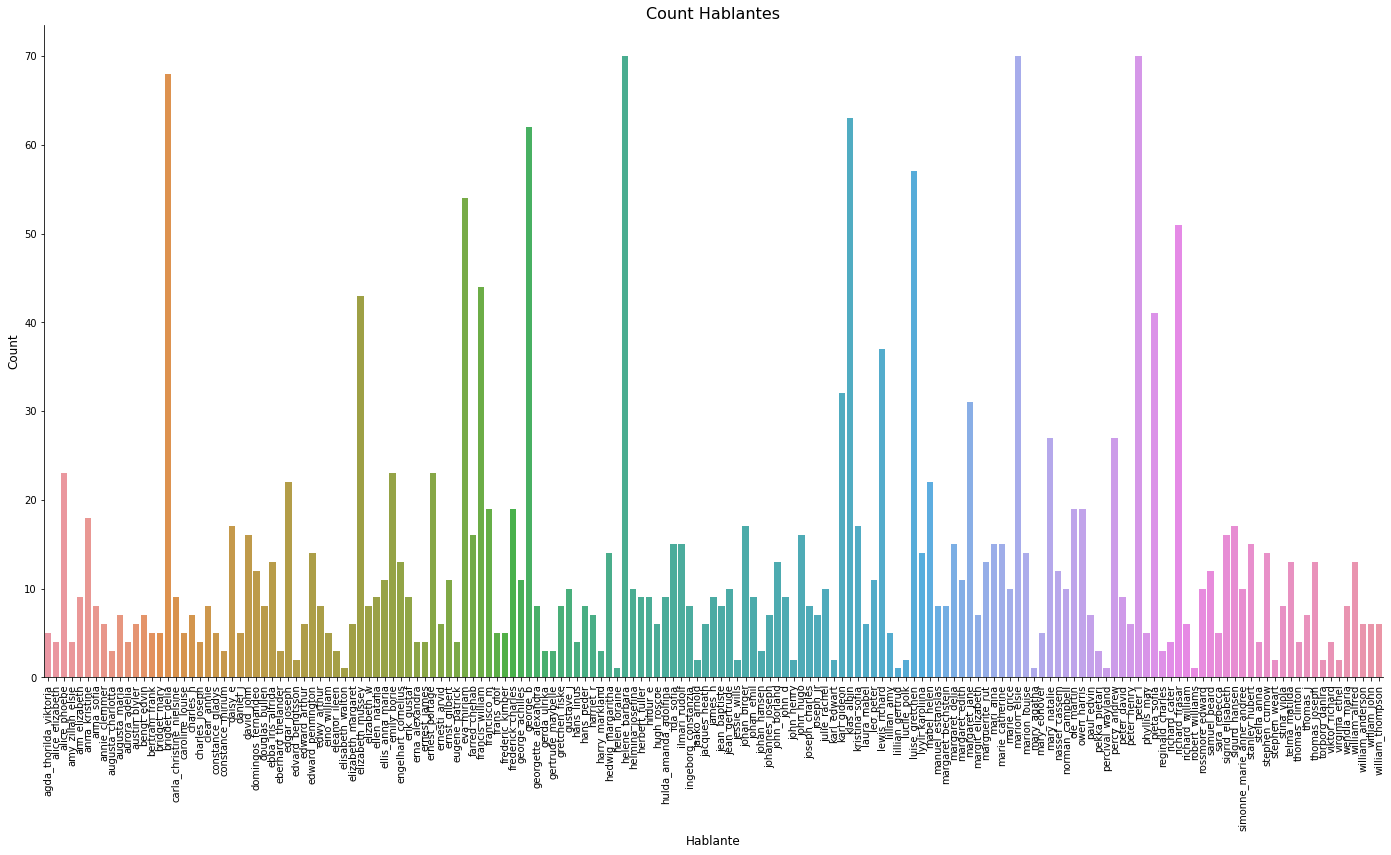

In [8]:

plt.figure(figsize=(24,12))
plt.title('Count Hablantes', size=16)
sns.countplot(x="label", data=data_train)
plt.ylabel('Count', size=12)
plt.xlabel('Hablante', size=12)
plt.xticks(rotation=90)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Carga de audios

Se carga 5 segundos de audio por hablante, en caso de que el hablante posea poca cantidad de audios se carga el audio entero para que posteriormente se divida en sub audios distintos, por otro lado se elimina el silencio de cada audio.

In [9]:
def get_clean_audio(data):
    wav_arr=[]
    for path, cont in zip(data.paths, data.cont):
        if(cont < min_limit):  #Si el hablante tiene menos cantidad de audios que el limite se cargan sus audios por completo
            aud, sr=librosa.load(path,sr=SAMPLE_RATE,res_type='kaiser_fast',offset=0.5)
        else:
            aud, sr=librosa.load(path,sr=SAMPLE_RATE,res_type='kaiser_fast',duration=DURATION)
        clip = librosa.effects.split(aud, top_db=15) #Se elimina el silencio de cada audio
        wav_data=[]
        for i in clip:
            wav_data.extend(aud[i[0]: i[1]])
        wav_arr.append(np.array(wav_data))
    return wav_arr

In [10]:
wavs_data=get_clean_audio(data_train) #Cargando audios

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# GENERANDO DATA ADICIONAL

Se divide los audios que fueron cargados por completo para balancear la data, adicionalmente se agrega ruido a esos audios (data artificial) para balancear aun más

In [12]:
def get_augmented_data(wav_d, data):
    augmented_data=[]
    augmented_label=[]
    for i, l, c in zip(wav_d, data.label, data.cont):
        d=librosa.get_duration(y=i,sr=SAMPLE_RATE)
        if(d > DURATION): #Si el audio dura mas que nuestro limite se crean mulitples clips de este
            cont = 0
            for elem in np.arange(0, (len(i) - len(i)%DURATION) - SAMPLE_RATE*DURATION, SAMPLE_RATE*DURATION):
                if(cont < max_limit//c): #no debe pasar nuestro maximo limite
                    augmented_data.append(i[elem: elem + SAMPLE_RATE*DURATION])
                    augmented_label.append(l)
                    cont += 1
            
    wav_upd = np.array([i for i, x in zip(wav_d, data.cont) if(x >= min_limit)])
    data = data[data.cont >= min_limit]
    
    augmented_data.append([0])
    augmented_data = np.array(augmented_data)
    augmented_label = np.array(augmented_label)
    
    new_wav=np.concatenate([wav_upd, augmented_data])[:-1]
    new_lab=np.concatenate([data.label.values, augmented_label])
    
    return new_wav, new_lab

In [13]:
new_wav, new_lab = get_augmented_data(wavs_data, data_train) #Obteniendo nuevos datos (wav , labels)

In [14]:
# Nuevos audios y sus labels correspondientes
new_wav.shape, new_lab.shape

((7085,), (7085,))

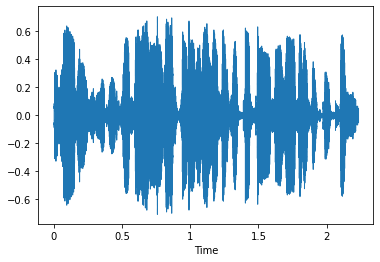

In [15]:
librosa.display.waveshow(new_wav[100])

# NUEVA DISTRIBUCION DE CLASES

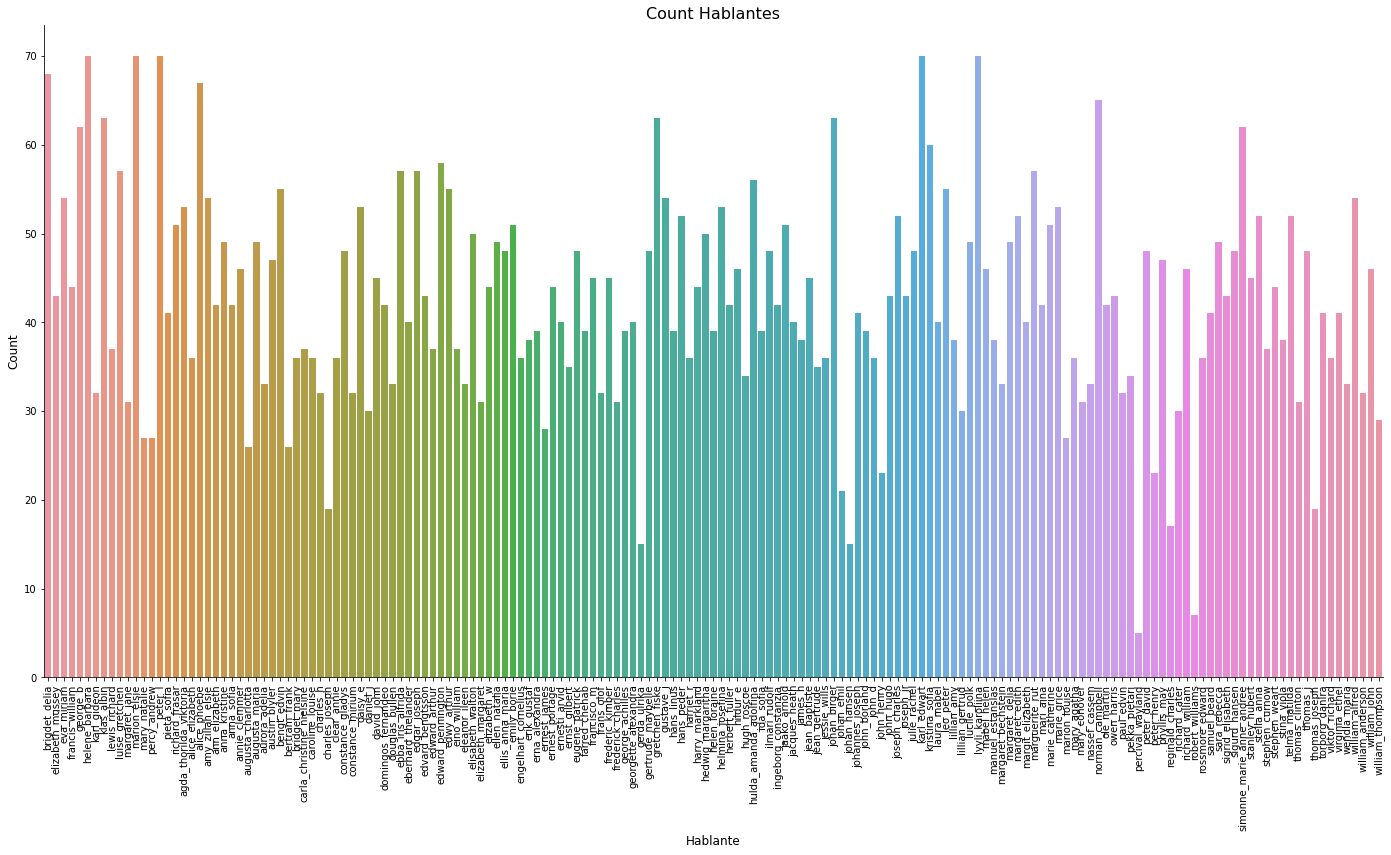

In [16]:
plt.figure(figsize=(24,12))
plt.title('Count Hablantes', size=16)
sns.countplot(x=new_lab)
plt.ylabel('Count', size=12)
plt.xlabel('Hablante', size=12)
plt.xticks(rotation=90)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# EXTRAYENDO ATRIBUTOS DE LOS AUDIOS

Codigo extraido de ayudantía 3

In [17]:
def extract_features(data):
    # ZCR
    sample_rate=SAMPLE_RATE
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [18]:
X = [extract_features(val) for val in new_wav]

In [19]:
def test2pred(data):
    wav_arr=[]
    for path in data.paths:
        aud=librosa.load(path,sr=SAMPLE_RATE,res_type='kaiser_fast',duration=10, offset=0.5)[0]
        clip = librosa.effects.split(aud, top_db=15)
        wav_data=[]
        for i in clip:
            wav_data.extend(aud[i[0]: i[1]])
        wav_arr.append(np.array(wav_data))
    test_data=[extract_features(val) for val in wav_arr]
    return test_data

In [20]:
test_data_1 = test2pred(data_test)

In [21]:
X = np.array(X)
Y = new_lab

# PREPARANDO DATOS PARA EL MODELO

In [22]:
encoder = OneHotEncoder()
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=0, shuffle=True, test_size=0.3)

y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_val = encoder.transform(y_val.reshape(-1,1)).toarray()

scaler  = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val   = scaler.transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)

In [23]:
test_data = scaler.transform(test_data_1)

# MODELO

In [24]:
model = Sequential()
model.add(Conv1D(256,3, padding='same',activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(256,3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(128,3, activation='relu',padding='same'))
model.add(Conv1D(128,3, activation='relu',padding='same'))
model.add(Conv1D(64,3, activation='relu',padding='same'))
model.add(Conv1D(64,3, activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(32,3,activation='relu', padding='same'))
model.add(Conv1D(32,3, activation='relu',padding='same'))
model.add(BatchNormalization())
model.add((LSTM(units=64,return_sequences=True)))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=167, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1024      
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 256)          196864    
                                                                 
 batch_normalization (BatchN  (None, 162, 256)         1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 162, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 81, 128)           9

# ENTRENANDO MODELO

In [25]:
rlrp = ReduceLROnPlateau(monitor = 'val_loss', factor=0.4, patience=5)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.005,
    restore_best_weights=True,
)

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), callbacks=[rlrp, early_stopping])

Epoch 1/100
78/78 [==============================] - 10s 65ms/step - loss: 4.4698 - accuracy: 0.1022 - val_loss: 5.0217 - val_accuracy: 0.0259 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - 3s 42ms/step - loss: 3.0427 - accuracy: 0.3188 - val_loss: 4.9575 - val_accuracy: 0.0226 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - 3s 41ms/step - loss: 2.2418 - accuracy: 0.4749 - val_loss: 4.7085 - val_accuracy: 0.0555 - lr: 0.0010
Epoch 4/100
78/78 [==============================] - 3s 42ms/step - loss: 1.6598 - accuracy: 0.6072 - val_loss: 4.3762 - val_accuracy: 0.0880 - lr: 0.0010
Epoch 5/100
78/78 [==============================] - 3s 41ms/step - loss: 1.2533 - accuracy: 0.7084 - val_loss: 3.8570 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 6/100
78/78 [==============================] - 3s 41ms/step - loss: 1.0244 - accuracy: 0.7493 - val_loss: 2.9970 - val_accuracy: 0.3170 - lr: 0.0010
Epoch 7/100
78/78 [==============================] - 3s 41ms/step - l

# RENDIMIENTO

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot( train_loss , label = 'Training Loss')
ax[0].plot( test_loss , label = 'Val Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot( train_acc , label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Val Accuracy')
ax[1].set_title('Training & Val Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Se observa overfit

Una posible causa puede ser el desbalance presente que se agrava al ser una gran cantidad de clase y la nula posibilidad de poder controlar el balance en la funcion train_test_split

# Submit a Kaggle

In [ ]:
test_d = np.expand_dims(test_data, axis=2)

pred   = model.predict(test_d)
pred_f = encoder.inverse_transform(tf.one_hot(tf.argmax(pred, axis = 1), depth = 167).numpy())

In [ ]:
final       = data_test.copy()
final['Id'] = data_test.paths.apply(lambda x : x[len(testpath)+1:])
final['Expected'] = pred_f
final.drop(['paths'], axis = 1, inplace = True)

In [ ]:
final.sort_values(by="Id")

In [ ]:
plt.figure(figsize=(24,12))
plt.title('Count Hablantes', size=16)
sns.countplot(x='Expected',data=final)
plt.ylabel('Count', size=12)
plt.xlabel('Hablante', size=12)
plt.xticks(rotation=90)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
final.to_csv('submission.csv',index=False)